In [126]:
%matplotlib inline
import pandas as pd
from time import sleep

import twitter
from twitter_accounts import accounts
from geotext import GeoText
from pygeocoder import Geocoder

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [23]:
app = accounts["social"]

auth = twitter.oauth.OAuth(
    app["token"],
    app["token_secret"],
    app["api_key"],
    app["api_secret"])

twitter_api = twitter.Twitter(auth=auth)

In [119]:
query = "pharo"
count = 200

search_results = twitter_api.search.tweets(q=query, count=count)

statuses = search_results["statuses"]
tweet_count = 0

while True:
    try:
        next_results = search_results["search_metadata"]["next_results"]

        args = dict(parse.parse_qsl(next_results[1:]))

        search_results = twitter_api.search.tweets(**args)
        statuses += search_results["statuses"]

        print(search_results["search_metadata"]["max_id"])
                
    except:
        break

955215943361277953
954567620543635455
953875527043026943
953236715573039103
952718962860666879


In [120]:
locations = [tweet['user']['location'] for tweet in statuses]
locations[:5]

['Tokyo', '', '', 'www.soundcloud.com/cight', '睡眠の重要性 / 神奈川県(Japan)']

In [121]:
cities = [GeoText(loc).cities for loc in locations]
countries = [GeoText(loc).countries for loc in locations]

In [122]:
def first_or_none(arr, i):
    if arr[i] == []:
        arr[i] = None
    else:
        arr[i] = arr[i][0]

In [123]:
for i in range(len(locations)):
    first_or_none(cities, i)
    first_or_none(countries, i)

In [124]:
places = pd.DataFrame({'city': cities, 'country': countries})
places = places.dropna(how='all')

print(len(places))
places.head()

242


,city,country
0,Tokyo,None
4,None,Japan
5,Tokyo,Japan
9,Marseille,France
10,Marseille,France


In [131]:
places['lat'] = None
places['lon'] = None
counter = 0

for index, row in places.iterrows():
    counter += 1
    
    # To avoid being blocked by Google API
    if counter % 25 == 0:
        print('Sleeping for 10 seconds...')
        sleep(10)
        
    if row['city'] != None:
        location = row['city']
    else:
        location = row['country']
        
    geocode = Geocoder.geocode(location)
    coord = geocode.coordinates
    
    row['lat'] = coord[0]
    row['lon'] = coord[1]

Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...
Sleeping for 10 seconds...


In [132]:
places.head()

,city,country,lat,lon
0,Tokyo,None,35.6895,139.692
4,None,Japan,36.2048,138.253
5,Tokyo,Japan,35.6895,139.692
9,Marseille,France,43.2965,5.36978
10,Marseille,France,43.2965,5.36978


/Users/oleks/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/oleks/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


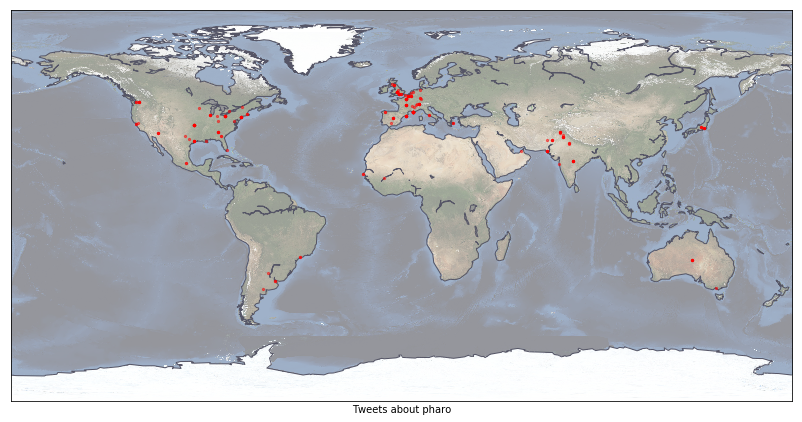

In [135]:
fig, ax = plt.subplots(figsize=(14, 8))
earth = Basemap()
earth.bluemarble(alpha=0.42)
earth.drawcoastlines(color='#555566', linewidth=1)
ax.scatter(places['lon'], places['lat'], 5, 
           c='red', alpha=0.5, zorder=10)
ax.set_xlabel("Tweets about {}".format(query))
plt.savefig('img/tweets.png', dpi=350, bbox_inches='tight')